Create a Folder in your Drive in your My Drive folder of your Drive and name it Minecraft Server
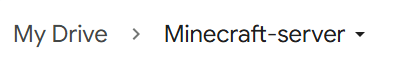

Now Upload All your world files here
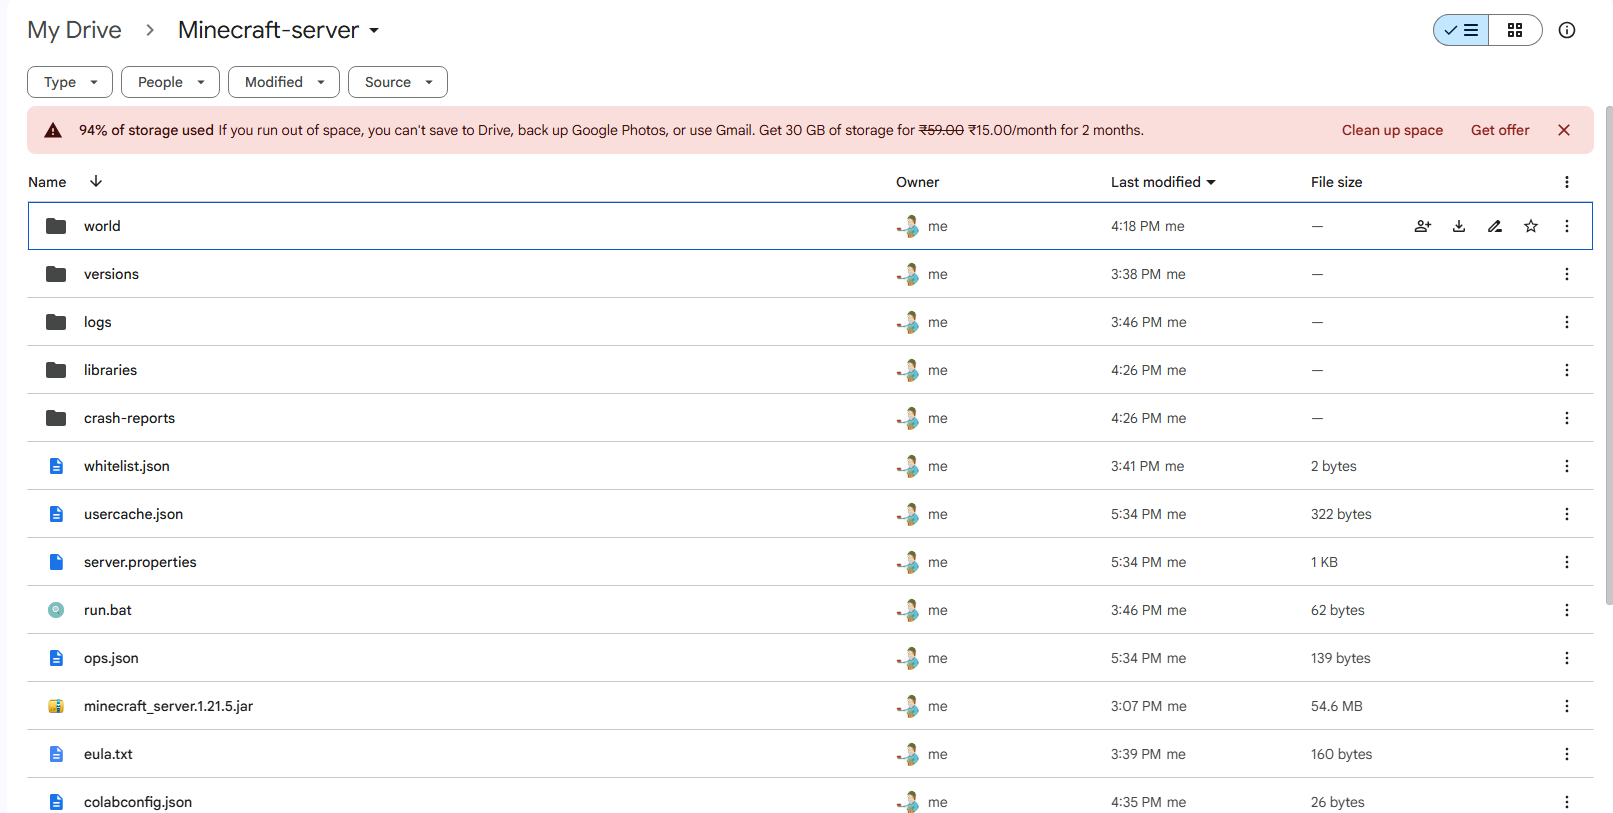
Now in the collab:
Press the bottom play sign to start the server

👇

In [ ]:
import os
import re
import json

# Update the package lists
!sudo apt update &>/dev/null && echo "apt cache successfully updated" || echo "apt cache update failed, you might receive stale packages"
# Install OpenJDK 17
# !wget -qO - https://adoptopenjdk.jfrog.io/adoptopenjdk/api/gpg/key/public | sudo apt-key add -
# !sudo add-apt-repository --yes https://adoptopenjdk.jfrog.io/adoptopenjdk/deb/ &>/dev/null || echo "Failed to add repo. Still can be ignored if openjdk17 gets installed."
!sudo apt-get install openjdk-21-jre-headless &>/dev/null && echo "Yay! Openjdk21 has been successfully installed." || echo "Failed to install OpenJdk17."
#Perform java version check

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory to the Minecraft server folder on Google Drive
%cd "/content/drive/My Drive/Minecraft-server"
!ls #list the directory contents (to verify that working directory was changed)

# Import config file.
if os.path.isfile("colabconfig.json"):
  colabconfig = json.load(open("colabconfig.json"))
else:
  colabconfig = {"server_type": "generic"} # using default, if config doesn't exists.
  json.dump(colabconfig, open("colabconfig.json",'w'))

# Server jar names.
jar_list = {'paper': 'server.jar', 'fabric': 'fabric-server-launch.jar', 'generic': 'server.jar', 'forge': 'server.jar'}
jar_name = jar_list[colabconfig["server_type"]]

# Java arguments.
if colabconfig["server_type"] == "paper":
  server_flags = "-XX:+UseG1GC -XX:+ParallelRefProcEnabled -XX:MaxGCPauseMillis=200 -XX:+UnlockExperimentalVMOptions -XX:+DisableExplicitGC -XX:+AlwaysPreTouch -XX:G1NewSizePercent=30 -XX:G1MaxNewSizePercent=40 -XX:G1HeapRegionSize=8M -XX:G1ReservePercent=20 -XX:G1HeapWastePercent=5 -XX:G1MixedGCCountTarget=4 -XX:InitiatingHeapOccupancyPercent=15 -XX:G1MixedGCLiveThresholdPercent=90 -XX:G1RSetUpdatingPauseTimePercent=5 -XX:SurvivorRatio=32 -XX:+PerfDisableSharedMem -XX:MaxTenuringThreshold=1 -Dusing.aikars.flags=https://mcflags.emc.gs -Daikars.new.flags=true"
else:
  server_flags = "" # aiker's flags might negatively impact performance on non-paper servers.
memory_allocation = "-Xmx6144M -Xms6144M"

# Chose the tunnle service you want to use
# Available options: ngrok, argo, playit
tunnel_service = "playit"
print("Procedding to use", tunnel_service)


if tunnel_service == "ngrok":
  !pip -q install pyngrok
  from pyngrok import conf, ngrok

  # Ask for the ngrok authtoken
  print("Get your authtoken from https://dashboard.ngrok.com/auth")
  import getpass
  authtoken = getpass.getpass()  # input your Ngrok auth token everytime you run the cell or simply replace "getpass.getpass()" with your token in "double quotes"
  ! ngrok authtoken $authtoken # login to ngrok

  # Sets default ngrok region
  conf.get_default().region = 'us'  # Change this to whichever region you want

  # Connect to ngrok
  url = ngrok.connect(25565, 'tcp')
  print('Your server address is ' + ((str(url).split('"')[1::2])[0]).replace('tcp://', ''))

  print('Starting server...')
  !java $memory_allocation $server_flags -jar $jar_name nogui

elif tunnel_service == "playit":
  ! curl -SsL https://playit-cloud.github.io/ppa/key.gpg | sudo apt-key add -
  ! sudo curl -SsL -o /etc/apt/sources.list.d/playit-cloud.list https://playit-cloud.github.io/ppa/playit-cloud.list
  ! sudo apt update &>/dev/null && sudo apt install playit &>/dev/null && echo "Playit.gg installed" || echo "Failed to install playit"
  print('Starting server...')
  ! playit & java -Xmx11144M -jar minecraft_server.1.21.5.jar nogui -

else:
  # Download & make argo executable
  !wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
  !chmod +x cloudflared-linux-amd64
  print('Starting server...')
  !./cloudflared-linux-amd64 tunnel --url tcp://127.0.0.1:25565 & java $memory_allocation $server_flags -jar $jar_name nogui
